In [1]:
%matplotlib inline

import os, sys, json, pickle, joblib, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import pylogit as pl
from collections import OrderedDict
from mode_logit import long_form_data, logit_spec, logit_est_disp, asclogit_pred

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Functions

In [2]:
def get_haversine_distance(point_1, point_2):
    """
    Calculate the distance between any 2 points on earth given as [lon, lat]
    return unit: meter
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [point_1[0], point_1[1], 
                                                point_2[0], point_2[1]])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_residence_workplace_distance(row, allow_different_work_city=False, unit='km'):
    if not all([(field in row and not np.isnan(row[field])) for field in ['Workplace_lng', 'Workplace_lat',
                                                                          'Residence_lng', 'Residence_lat']]):
        return None
    if 'Work_City' in row and row['Work_City'] != 'Shenzhen' and not allow_different_work_city:
        return None
    residence_coords = [row['Residence_lng'], row['Residence_lat']]
    workplace_coords = [row['Workplace_lng'], row['Workplace_lat']]
    try:
        dist = get_haversine_distance(residence_coords, workplace_coords)
        if unit == 'km':
            dist /= 1000
        return dist
    except:
        return None
    
def get_trip_duration(row, unit='hour'):
    from_time, to_time = row['From_Time'], row['To_Time']
    from_time_hour, from_time_min = [float(x) for x in from_time.split(':')]
    to_time_hour, to_time_min = [float(x) for x in to_time.split(':')]
    if to_time_hour < from_time_hour:
        to_time_hour += 24   # assuming the next day
    dur_min = (to_time_hour - from_time_hour) * 60 + to_time_min - from_time_min
    if unit == 'hour':
        duration = dur_min/60
    elif unit == 'min':
        duration = dur_min
    elif unit == 'sec':
        duration = dur_min*60
    return duration

def get_mode_cat(row):
    map_dict = {
        "Walk": "walk",
        "Metro": "pt",
        "Private Car (Driving)": "drive",
        "Bus": "pt",
        "Shared Bike": "cycle",
        "Taxi": "taxi",
        "Bike": "cycle",
        "E-Bike": "cycle",  
        "Private Car (Shared Ride)": "taxi",
        "Online Bus Hailing": "taxi",
        "Company Car": "drive",
        "Online Other Car Hailing": "taxi",
    }
    return map_dict.get(row['Main_Mode'], 'others')

def get_place_type(row, place_identifier, tolerance=100):
    place_coord = [row[f'{place_identifier}_lng'], row[f'{place_identifier}_lat']]
    home_coord = [row['Residence_lng'], row['Residence_lat']]
    if get_haversine_distance(place_coord, home_coord) <= tolerance:
        return 'H'
    if row['Workplace_lng'] is not None and not np.isnan(row['Workplace_lng']):
        workplace_coord = [row['Workplace_lng'], row['Workplace_lat']]
        if get_haversine_distance(place_coord, workplace_coord) <= tolerance:
            return 'W'
    return 'O'

def get_trip_purpose(row):
    tmp = [row['from_place_type'], row['to_place_type']]
    if 'H' in tmp and 'W' in tmp:
        return 'HBW'
    if 'H' in tmp and 'W' not in tmp:
        return 'HBO'
    if 'H' not in tmp:
        return 'NHB'
    
def pretty_print_confusion_matrix(confusion_matrix, labels, order=None, name=None):
    if order is not None:
        idx_order = [labels.index(label) for label in order]
        confusion_matrix = confusion_matrix[idx_order]
        confusion_matrix = confusion_matrix[:, idx_order]
        labels = order
    cmat_df = pd.DataFrame(confusion_matrix, columns=[f'{l}_pred' for l in labels], 
                          index=[f'{l}_true' for l in labels])
    name = '' if name is None else f'for {name}'
    print('\nConfusion matrix ' + name + '\n')
    print(tabulate(cmat_df, showindex=True, headers='keys'))
    metric_df = cmat_df.sum(axis=1).to_frame(name='sum_true').rename(index={f'{m}_true': m for m in modes})
    metric_df['sum_pred'] = cmat_df.sum(axis=0).to_frame(name='sum_pred').rename(index={f'{m}_pred': m for m in modes})
    metric_df['TP'] = np.diag(confusion_matrix)
    metric_df['precision'] = metric_df['TP'] / metric_df['sum_pred']
    metric_df['recall'] = metric_df['TP'] / metric_df['sum_true']
    metric_df['f1'] = 2 * (metric_df['precision'] * metric_df['recall']) / (metric_df['precision'] + metric_df['recall'])
    print('\nMetrics ' + name + '\n')
    print(tabulate(metric_df, showindex=True, headers='keys'))
#     acc = np.sum(np.diag(confusion_matrix)) / confusion_matrix.sum()
#     print(f'\nOveral accuracy {name}: {acc:4.4f}')
        
def get_trip_time_predictor(trip_time, features, n_estimators=20, test_size=0.2, random_state=1):
    predictor = RandomForestRegressor(n_estimators=n_estimators)
    x_train, x_test, y_train, y_test = train_test_split(features, trip_time, test_size=test_size, random_state=random_state)
    randomGrid = {'max_depth': range(5,50,5), 'min_samples_leaf': range(1,101,10)}

    # Create the random search object
    predictor_random_search = RandomizedSearchCV(estimator=predictor, param_distributions = randomGrid,
                                   n_iter=64, cv = 4, verbose=1, random_state=random_state, 
                                   refit=True, scoring='neg_mean_squared_error', n_jobs=-1)

    # Perform the random search and find the best parameter set
    predictor_random_search.fit(x_train, y_train)
    winner = predictor_random_search.best_estimator_
    bestParams = predictor_random_search.best_params_
    return winner, bestParams

# Data Preparing

### Load Household Travel Survey Data 

In [5]:
workding_dir = 'E:/01 - L3/Shenzhen CityScope/data/forMIT/NHTS_data_wgs84_biased_censored'

households_path = 'HTS_households_RA.csv'
persons_path = 'HTS_persons_RA.csv'
trips_path = 'HTS_trips_RA.csv'

In [6]:
hhs_df = pd.read_csv(os.path.join(workding_dir, households_path), encoding='utf-8')
persons_df = pd.read_csv(os.path.join(workding_dir, persons_path), encoding='utf-8')
trips_df = pd.read_csv(os.path.join(workding_dir, trips_path), encoding='utf-8')
trips_cp_df = trips_df.copy()
# assert all([trips_HH_ID in list(hhs_df['HH_ID']) for trips_HH_ID in list(trips_df['HH_ID'])])
# assert all([trips_Person_ID in list(perons_df['Person_ID']) for trips_Person_ID in list(trips_df['Person_ID'])])

### Preprocessing

In [7]:
# get home_workplace distance
persons_df = persons_df.merge(hhs_df[['HH_ID', 'Residence_lng', 'Residence_lat']], 
                              how='inner', on='HH_ID', suffixes=('', '_hhs'))
persons_df['home_work_dist'] = persons_df.apply(lambda row: get_residence_workplace_distance(row), axis=1)

# get some useful features
hhs_df['num_all_bikes'] = hhs_df['Num_Bike'] + hhs_df['Num_Motorcycle'] + hhs_df['Num_E_Bike']
hhs_df['num_all_vehicles'] = hhs_df['Num_Private_Car'] + hhs_df['Num_Van'] + hhs_df['Num_Public_Car']
persons_df.loc[persons_df['Income'].isnull(), 'Income'] = 0  # almost all of NaN-income records are students

# get trips distance and duration
trips_df = trips_df.loc[trips_df['From_City']==trips_df['To_City']]
trips_df = trips_df.loc[trips_df['From_City']=='Shenzhen']
trips_df['trip_dist_calc'] = trips_df.apply(lambda row: get_haversine_distance(
    [row['From_lng'], row['From_lat']], [row['To_lng'], row['To_lat']]) / 1000, axis=1)
trips_df['trip_duration'] = trips_df.apply(lambda row: get_trip_duration(row), axis=1)
trips_df['trip_speed'] = trips_df['Trip_Dist'] / trips_df['trip_duration']
trips_df['mode'] = trips_df.apply(lambda row: get_mode_cat(row), axis=1)

# merging housholds, persons, trips 
merge_hh_feilds = ['HH_ID', 'HH_Size', 'HH_Anual_Income', 'Residence_lng', 'Residence_lat',
                   'Residence_Type', 'num_all_vehicles', 'num_all_bikes']
merge_person_fields = ['Person_ID', 'Age', 'Gender', 'Register_in_SZ', 'Education', 'Income', 
                       'Occupation', 'Workplace_lng', 'Workplace_lat', 'Work_City', 'home_work_dist']
trips_df = trips_df.merge(hhs_df[merge_hh_feilds], how='inner', on='HH_ID', suffixes=('', '_hhs'))
trips_df = trips_df.merge(persons_df[merge_person_fields], how='inner', on='Person_ID', suffixes=('', '_persons'))

# get trip purpose (HBW, HBO, NHB)
trips_df['from_place_type'] = trips_df.apply(lambda row: get_place_type(row, 'From'), axis=1)
trips_df['to_place_type'] = trips_df.apply(lambda row: get_place_type(row, 'To'), axis=1)
trips_df['trip_purpose'] = trips_df.apply(lambda row: get_trip_purpose(row), axis=1)

In [6]:
# trips_df.loc[trips_df['Trip_Purpose']=='Go Home', [
#     'Residence_lng', 'Residence_lat','Workplace_lng', 'Workplace_lat', 
#     'From_lng', 'From_lat', 'from_place_type','To_lng', 'To_lat', 'to_place_type', 'Trip_Purpose']].head(30)
# trips_df[['Trip_Purpose', 'trip_purpose']].head(20)

# check trip spatiotemporal info: distance in decent order
# Trip_Dist is provided by data source, and trip_dist_calc is calculated using lng-lat coordinates. Using the former.
# trips_df[['mode', 'From_lng', 'From_lat', 'To_lng', 'To_lat', 'From_Time', 'To_Time', 
#           'Trip_Dist', 'trip_dist_calc', 'trip_duration', 'trip_speed']].sort_values('Trip_Dist', ascending=False).head()

### Estimating speed for different modes 

Estimated speed: 
cycle: 4.70km/s (cum_dist/cum_time), 5.22km/s (average over trip_speed)
drive: 14.96km/s (cum_dist/cum_time), 14.10km/s (average over trip_speed)
pt: 9.76km/s (cum_dist/cum_time), 10.04km/s (average over trip_speed)
taxi: 13.97km/s (cum_dist/cum_time), 13.31km/s (average over trip_speed)
walk: 2.89km/s (cum_dist/cum_time), 3.52km/s (average over trip_speed)


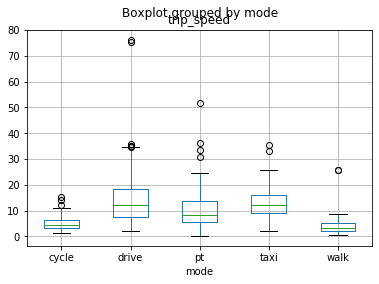

In [8]:
modes = {mode:{} for mode in np.unique(list(trips_df['mode']))}
for mode in modes:
    cum_dist_km = trips_df.loc[trips_df['mode']==mode, 'Trip_Dist'].sum()
    cum_time_hour = trips_df.loc[trips_df['mode']==mode, 'trip_duration'].sum()
    modes[mode]['mean_speed'] = cum_dist_km / cum_time_hour
    modes[mode]['mean_speed2'] = trips_df.loc[trips_df['mode']==mode, 'trip_speed'].mean()
    """
    # estimate a random forest regressor to predict travel time
    # do not use it 
    trip_time = trips_df.loc[trips_df['mode']==mode, 'trip_duration']
    use_predictor_columns = ['Trip_Dist']
    features = trips_df.loc[trips_df['mode']==mode, use_predictor_columns]
    trip_time_predictor, bestParams = get_trip_time_predictor(trip_time, features)
    modes[mode]['trip_time_predictor'] = trip_time_predictor
    modes[mode]['trip_time_predictor_bestParams'] = bestParams
    """

print('Estimated speed: ')
for mode, attr in modes.items():
    print('{}: {:4.2f}km/s (cum_dist/cum_time), {:4.2f}km/s (average over trip_speed)'.format(mode, attr['mean_speed'], attr['mean_speed2']))

trips_df.boxplot(column='trip_speed', by='mode')

In [8]:
# syn_data = pd.DataFrame(np.linspace(0.1, 40, 100).reshape(-1,1), columns=['Trip_Dist'])
# for mode in modes:
#     syn_data[f'{mode}_time_pred'] = modes[mode]['trip_time_predictor'].predict(syn_data[['Trip_Dist']])
    
# syn_data.plot(x='Trip_Dist', y=[f'{mode}_time_pred' for mode in modes])

### Generate Mode Choice Dataset

In [9]:
mocho_df = pd.DataFrame()
for field in ['mode', ('Trip_Dist', 'network_dist_km')]:
    if type(field) == str:
        mocho_df[field] = trips_df[field]
    elif type(field) == tuple:
        mocho_df[field[1]] = trips_df[field[0]]
for mode in modes:
    mocho_df[f'{mode}_time_mins'] = trips_df['Trip_Dist'] / modes[mode]['mean_speed'] * 60
    mocho_df.loc[mocho_df['mode']==mode, f'{mode}_time_mins'] = trips_df.loc[
        mocho_df['mode']==mode, 'trip_duration'] * 60
trip_purpose_dummys = pd.get_dummies(trips_df['trip_purpose'], prefix='purpose')
mocho_df = pd.concat([mocho_df, trip_purpose_dummys],  axis=1)

In [10]:
hh_fields = ['HH_Size', 'HH_Anual_Income', 'Residence_Type', 'num_all_vehicles', 'num_all_bikes']
person_fields = ['Age', 'Gender', 'Register_in_SZ', 'Education', 'Income', 'Occupation']
hh_person_cat_field_lookup = {
    'HH_Anual_Income': {
        'a ≤10': 'lt20', 
        'b 10-20': 'lt20', 
        'c 20-30': '20-30', 
        'd 30-50': '30-50', 
        'e 50-100': 'gt50', 
        'f 100以上': 'gt50',
    },
    'Residence_Type': {
        'Affordable Puchasing Housing': 'affordable',
        'Affordable Renting Housing': 'affordable',
        'Dormitory': 'affordable',
        'Market Puchasing Housing': 'marketprice',
        'Urban Village': 'affordable',
    },
    'Gender': {'Male':'male', 'Female':'female'},
    'Register_in_SZ': {'True':'yes', 'False':'no', True:'yes', False:'no'},
    'Education': {
        'Bachelor': 'college', 
        'Junior Middle School and Below': 'EMH_school', 
        'Senior Middle School': 'EMH_school', 
        'Ph.D': 'master_phd', 
        'Secondary Vocational School': 'EMH_school', 
        'Vocational College': 'college', 
        'Master': 'master_phd',
    },
    'Income': {
        '10-15': '10_15', 
        'GT 50': 'gt30', 
        'LT 10': 'lt10', 
        '15-20': '15_20', 
        '30-50': 'gt30', 
        '20-30': '20_30',
        0: 'lt10',
    },
    'Occupation': {
        'Company Business Personnel': 'manager', 
        'Self-Employed Worker': 'free', 
        'Servant': 'employee', 
        'University Student': 'student', 
        'Health Worker': 'employee', 
        'Unemployment': 'unemployment', 
        'Company Common Employee': 'employee', 
        'Civil Servant': 'employee', 
        'Retired': 'retired', 
        'Free Occupation': 'free', 
        'Company Manager': 'manager',
        'Primary / Middle School Student': 'student', 
        'Teacher': 'employee',
    }
}

for field in person_fields+hh_fields:
    if field in hh_person_cat_field_lookup:
        cat_field = trips_df.apply(
            lambda row: hh_person_cat_field_lookup[field].get(row[field], 'others'), axis=1)
        dummies = pd.get_dummies(cat_field, prefix=field.lower())
        mocho_df = pd.concat([mocho_df, dummies],  axis=1)
    else:
        mocho_df[field.lower()] = trips_df[field]

### Mode Choice Dataset Summary

In [11]:
mocho_df.head()

,mode,network_dist_km,cycle_time_mins,drive_time_mins,pt_time_mins,taxi_time_mins,walk_time_mins,purpose_HBO,purpose_HBW,purpose_NHB,age,gender_female,gender_male,register_in_sz_no,register_in_sz_yes,education_EMH_school,education_college,education_master_phd,education_others,income_10_15,income_15_20,income_20_30,income_gt30,income_lt10,occupation_employee,occupation_free,occupation_manager,occupation_others,occupation_retired,occupation_student,occupation_unemployment,hh_size,hh_anual_income_20-30,hh_anual_income_30-50,hh_anual_income_gt50,hh_anual_income_lt20,residence_type_affordable,residence_type_marketprice,residence_type_others,num_all_vehicles,num_all_bikes
0,drive,4.000383,51.069282,20.000000,24.584525,17.183741,83.167849,0,1,0,37,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,4,0,1,0,0,0,1,0,1,0
1,drive,4.000383,51.069282,20.000000,24.584525,17.183741,83.167849,0,1,0,37,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,4,0,1,0,0,0,1,0,1,0
2,walk,1.215400,15.515916,4.876159,7.469293,5.220780,30.000000,1,0,0,37,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,1,0,0,0,1,0,1,0
3,walk,1.215400,15.515916,4.876159,7.469293,5.220780,30.000000,1,0,0,37,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,1,0,0,0,1,0,1,0
4,walk,0.369249,4.713869,1.481419,2.269236,1.586118,20.000000,0,1,0,11,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,4,0,1,0,0,0,1,0,1,0


In [12]:
mocho_df.describe()

,network_dist_km,cycle_time_mins,drive_time_mins,pt_time_mins,taxi_time_mins,walk_time_mins,purpose_HBO,purpose_HBW,purpose_NHB,age,gender_female,gender_male,register_in_sz_no,register_in_sz_yes,education_EMH_school,education_college,education_master_phd,education_others,income_10_15,income_15_20,income_20_30,income_gt30,income_lt10,occupation_employee,occupation_free,occupation_manager,occupation_others,occupation_retired,occupation_student,occupation_unemployment,hh_size,hh_anual_income_20-30,hh_anual_income_30-50,hh_anual_income_gt50,hh_anual_income_lt20,residence_type_affordable,residence_type_marketprice,residence_type_others,num_all_vehicles,num_all_bikes
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,3.422743,43.695074,13.731972,21.034614,14.702475,71.158732,0.394177,0.481523,0.124300,38.223964,0.534155,0.465845,0.313550,0.686450,0.279955,0.521837,0.071669,0.126540,0.211646,0.105263,0.059351,0.064950,0.558791,0.395297,0.072788,0.133259,0.004479,0.189250,0.162374,0.042553,3.402016,0.185890,0.319149,0.201568,0.293393,0.192609,0.791713,0.015677,0.769317,0.350504
std,5.114322,65.268868,18.090402,29.625421,21.592256,106.289940,0.488947,0.499938,0.330109,18.459300,0.499112,0.499112,0.464196,0.464196,0.449229,0.499803,0.258083,0.332643,0.408704,0.307064,0.236412,0.246575,0.496810,0.489188,0.259934,0.340045,0.066815,0.391926,0.369000,0.201961,1.753496,0.389236,0.466408,0.401396,0.455572,0.394570,0.406310,0.124294,0.684943,0.771764
min,0.336633,4.297490,1.350564,2.068793,1.446015,5.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.544677,6.953400,2.185233,3.347336,2.339673,15.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.221697,19.274753,5.873184,9.278780,6.272844,30.000000,0.000000,0.000000,0.000000,38.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,3.791922,46.783307,17.063800,29.889437,16.571246,77.530461,1.000000,1.000000,0.000000,51.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,38.141027,486.912095,138.536612,234.397314,163.835693,792.950871,1.000000,1.000000,1.000000,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000


# Random Forest Classifier 

### Random Forest Classifier Estimation 

In [11]:
features=[c for c in mocho_df.columns if not c=='mode']

X = mocho_df[features]
y = mocho_df['mode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
rf = RandomForestClassifier(n_estimators =32, random_state=0, class_weight='balanced')

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node

#Create the grid
randomGrid = {'max_depth': maxDepth,'min_samples_split': minSamplesSplit,'min_samples_leaf': minSamplesLeaf}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator = rf, param_distributions = randomGrid,
                               n_iter = 512, cv = 5, verbose=1, random_state=0, 
                               refit=True, scoring='f1_macro', n_jobs=-1)

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner=rfRandom.best_estimator_
rfBestParams=rfRandom.best_params_

joblib.dump({'model':rfWinner, 'bestParams':rfBestParams}, 'mocho_rf.p')
print(f'Best score for random forest: {rfRandom.best_score_}')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 1540 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 2440 tasks      | elapsed:  1.2min


Best score for random forest: 0.8672044972339095


[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:  1.3min finished


### Feature Importance 

In [15]:
%matplotlib qt
importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 15))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

Feature ranking:
1. taxi_time_mins (0.123729)
2. drive_time_mins (0.120815)
3. pt_time_mins (0.118088)
4. cycle_time_mins (0.110101)
5. network_dist_km (0.072511)
6. walk_time_mins (0.066268)
7. age (0.053126)
8. num_all_bikes (0.039777)
9. num_all_vehicles (0.039702)
10. hh_size (0.021525)
11. purpose_HBO (0.019643)
12. purpose_HBW (0.018560)
13. income_lt10 (0.015451)
14. education_EMH_school (0.014024)
15. occupation_employee (0.011812)
16. register_in_sz_yes (0.011253)
17. gender_female (0.011100)
18. education_college (0.011084)
19. hh_anual_income_30-50 (0.011070)
20. register_in_sz_no (0.010213)
21. gender_male (0.009999)
22. occupation_manager (0.009179)
23. income_15_20 (0.008730)
24. hh_anual_income_lt20 (0.008463)
25. income_gt30 (0.007257)
26. hh_anual_income_gt50 (0.007212)
27. purpose_NHB (0.006755)
28. residence_type_marketprice (0.006406)
29. occupation_retired (0.005632)
30. residence_type_affordable (0.005161)
31. income_10_15 (0.004850)
32. hh_anual_income_20-30 (0.0

### Train/Test Performance

In [16]:
labels = ['cycle', 'drive', 'pt', 'taxi', 'walk']
order = ['drive', 'taxi', 'cycle', 'walk', 'pt']

y_train_pred = rfWinner.predict(X_train)
conf_mat_train = confusion_matrix(y_train, y_train_pred)
pretty_print_confusion_matrix(conf_mat_train, labels, order, name='trainning data using random forest classifier')
print('\nOverall metrics for trainning data using random forest classifier: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred, average='macro')
))


print('')
y_test_pred = rfWinner.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_pred)
pretty_print_confusion_matrix(conf_mat_test, labels, order, name='test data using random forest classifier')
print('\nOverall metrics for test data using random forest classifier: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='macro')
))


Confusion matrix for trainning data using random forest classifier

              drive_pred    taxi_pred    cycle_pred    walk_pred    pt_pred
----------  ------------  -----------  ------------  -----------  ---------
drive_true           101            0             0            0          0
taxi_true              0           49             0            0          0
cycle_true             0            0            72            0          0
walk_true              0            0             0          342          0
pt_true                0            0             0            0        150

Metrics for trainning data using random forest classifier

         sum_true    sum_pred    TP    precision    recall    f1
-----  ----------  ----------  ----  -----------  --------  ----
drive         101         101   101            1         1     1
taxi           49          49    49            1         1     1
cycle          72          72    72            1         1     1
walk          

# Gradient Boosting Classifier

### Gradient Boosting Classifier Estimation 

In [17]:
gb = GradientBoostingClassifier(n_estimators =32, random_state=0)

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node
lr = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

#Create the grid
randomGrid = {'max_depth': maxDepth,'min_samples_split': minSamplesSplit,
              'min_samples_leaf': minSamplesLeaf, 'learning_rate': lr}

# Create the random search object
gbRandom = RandomizedSearchCV(estimator = gb, param_distributions = randomGrid,
                               n_iter = 512, cv = 5, verbose=1, random_state=0, 
                               refit=True, scoring='f1_macro', n_jobs=-1)

# Perform the random search and find the best parameter set
gbRandom.fit(X_train, y_train)
gbWinner=gbRandom.best_estimator_
gbBestParams=gbRandom.best_params_

# Save
joblib.dump({'model':gbWinner, 'bestParams':gbBestParams}, 'mocho_gb.p')
print(f'Best score for GBDT: {gbRandom.best_score_}')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed: 11.5min finished


Best score for GBDT: 0.9254702253044416


### Feature Importance 

Feature ranking:
1. cycle_time_mins (0.275294)
2. pt_time_mins (0.206443)
3. drive_time_mins (0.170056)
4. network_dist_km (0.063363)
5. taxi_time_mins (0.056988)
6. num_all_vehicles (0.048242)
7. walk_time_mins (0.046396)
8. num_all_bikes (0.037741)
9. age (0.020668)
10. income_gt30 (0.009597)
11. occupation_free (0.007549)
12. purpose_HBO (0.007482)
13. hh_size (0.006070)
14. residence_type_others (0.005064)
15. occupation_retired (0.004559)
16. income_20_30 (0.003850)
17. income_lt10 (0.003803)
18. education_master_phd (0.003138)
19. occupation_unemployment (0.002989)
20. gender_female (0.002740)
21. purpose_NHB (0.002695)
22. hh_anual_income_lt20 (0.002637)
23. purpose_HBW (0.002257)
24. education_EMH_school (0.001641)
25. occupation_student (0.001512)
26. hh_anual_income_gt50 (0.001474)
27. occupation_manager (0.001216)
28. income_15_20 (0.000882)
29. hh_anual_income_20-30 (0.000746)
30. residence_type_affordable (0.000634)
31. occupation_employee (0.000565)
32. education_college 

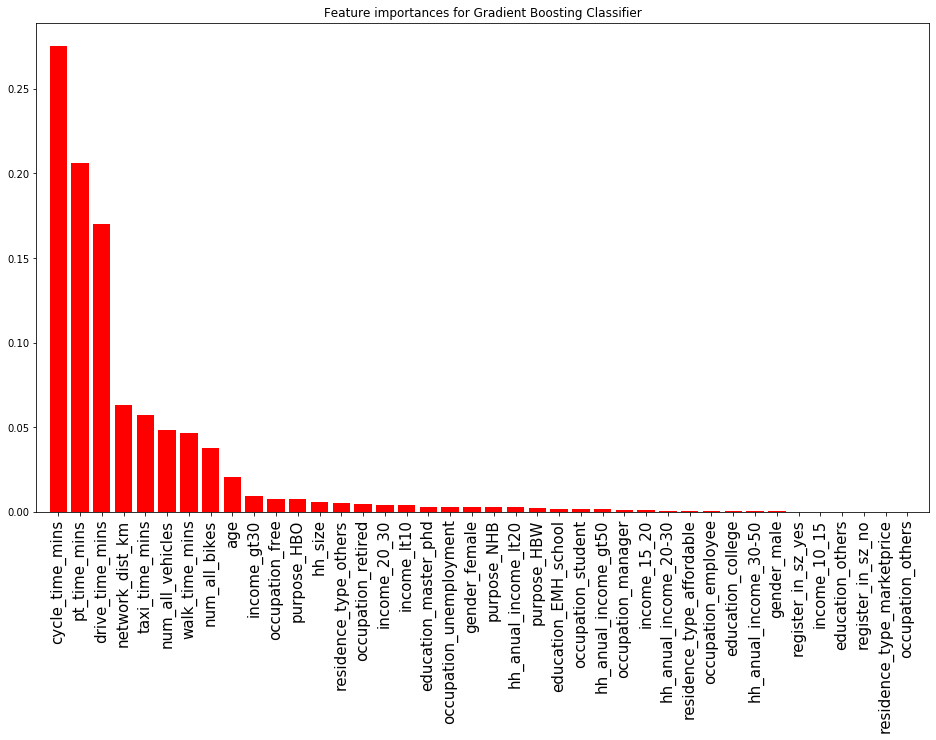

In [18]:
importances = gbWinner.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances for Gradient Boosting Classifier")
plt.bar(range(len(features)), importances[indices],color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

### Train/Test Performance

In [19]:
labels = ['cycle', 'drive', 'pt', 'taxi', 'walk']
order = ['drive', 'taxi', 'cycle', 'walk', 'pt']

y_train_pred = gbWinner.predict(X_train)
conf_mat_train = confusion_matrix(y_train, y_train_pred)
pretty_print_confusion_matrix(conf_mat_train, labels, order, name='trainning data using gradient boosting classifier')
print('\nOverall metrics for trainning data using gradient boosting classifier: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred, average='macro')
))

print('')
y_test_pred = gbWinner.predict(X_test)
conf_mat_test = confusion_matrix(y_test, y_test_pred)
pretty_print_confusion_matrix(conf_mat_test, labels, order, name='test data using gradient boosting classifier')
print('\nOverall metrics for test data using gradient boosting classifier: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average='macro')
))


Confusion matrix for trainning data using gradient boosting classifier

              drive_pred    taxi_pred    cycle_pred    walk_pred    pt_pred
----------  ------------  -----------  ------------  -----------  ---------
drive_true           101            0             0            0          0
taxi_true              0           49             0            0          0
cycle_true             0            0            72            0          0
walk_true              0            0             0          342          0
pt_true                0            0             0            0        150

Metrics for trainning data using gradient boosting classifier

         sum_true    sum_pred    TP    precision    recall    f1
-----  ----------  ----------  ----  -----------  --------  ----
drive         101         101   101            1         1     1
taxi           49          49    49            1         1     1
cycle          72          72    72            1         1     1
walk  

# Logit Model

### Create logit long-form table 

In [20]:
alt_attrs = {
    'time_mins': [
        'drive_time_mins', 'taxi_time_mins', 'cycle_time_mins', 'walk_time_mins', 'pt_time_mins'
    ],
}
generic_attrs = [x for x in mocho_df.columns if x != 'mode' and x not in sum(list(alt_attrs.values()), [])]
exclude_ref = [
    'purpose_HBW', 'gender_male', 'register_in_sz_yes', 'education_college', 
    'income_10_15', 'occupation_employee', 'hh_anual_income_20-30', 
    'residence_type_marketprice'
]
exclude_others = ['network_dist_km',
                 ]  
exclude_generic_attrs = exclude_ref + exclude_others
generic_attrs = [x for x in generic_attrs if x not in exclude_generic_attrs]
modes_in_order = ['drive', 'taxi', 'cycle', 'walk', 'pt']
mocho_logit_df = long_form_data(mocho_df, alt_attrs=alt_attrs, generic_attrs=generic_attrs, modes=modes_in_order)

# using the same train/test split for logit long-form data
# notice: group index must keep increasing, otherwise pylogit will throw error for ensure_contiguity_in_observation_rows
tranning_idx, test_idx = list(X_train.index), list(X_test.index)
mocho_logit_df_train = mocho_logit_df.loc[mocho_logit_df['group'].isin(tranning_idx)]
mocho_logit_df_test = mocho_logit_df.loc[mocho_logit_df['group'].isin(test_idx)]

In [21]:
model_train, numCoefs = logit_spec(mocho_logit_df_train, 
                                   alt_attr_vars = list(alt_attrs.keys()), 
                                   generic_attrs = generic_attrs, 
                                   constant = True, 
                                   alts = modes_in_order)
logit_est_rst_dict = logit_est_disp(model_train, numCoefs, nalt=5, disp=True)

Log-likelihood at zero: -1,149.1387
Initial Log-likelihood: -1,149.1387
Estimation Time for Point Estimation: 2.38 seconds.
Final log-likelihood: -495.0104
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                      choice   No. Observations:                  714
Model:             Multinomial Logit Model   Df Residuals:                      605
Method:                                MLE   Df Model:                          109
Date:                     Tue, 07 Sep 2021   Pseudo R-squ.:                   0.569
Time:                             15:12:32   Pseudo R-bar-squ.:               0.474
AIC:                             1,208.021   Log-Likelihood:               -495.010
BIC:                             1,706.247   LL-Null:                    -1,149.139
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

### Train/Test Performance

In [23]:
labels = ['cycle', 'drive', 'pt', 'taxi', 'walk']
order = ['drive', 'taxi', 'cycle', 'walk', 'pt']

pred_prob_train, y_train_pred, v = asclogit_pred(mocho_logit_df_train, logit_est_rst_dict, 
        customIDColumnName='group', alts=modes_in_order, method='max', seed=1)
y_train_pred = [modes_in_order[y] for y in y_train_pred]
y_train_true = np.array(mocho_logit_df_train['choice']).reshape(-1, len(modes_in_order)).argmax(axis=1)
y_train_true = [modes_in_order[y] for y in y_train_true]
conf_mat_train=confusion_matrix(y_train_true, y_train_pred)

pretty_print_confusion_matrix(conf_mat_train, labels, order, name='trainning data using MNL')
print('\nOverall metrics for trainning data using MNL: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_train_true, y_train_pred), f1_score(y_train, y_train_pred, average='macro')
))

pred_prob_test, y_test_pred, v = asclogit_pred(mocho_logit_df_test, logit_est_rst_dict, 
        customIDColumnName='group', alts=modes_in_order, method='max', seed=1)
y_test_pred = [modes_in_order[y] for y in y_test_pred]
y_test_true = np.array(mocho_logit_df_test['choice']).reshape(-1, len(modes_in_order)).argmax(axis=1)
y_test_true = [modes_in_order[y] for y in y_test_true]
conf_mat_test = confusion_matrix(y_test_true, y_test_pred)

pretty_print_confusion_matrix(conf_mat_test, labels, order, name='test data using MNL')
print('\nOverall metrics for test data using MNL: accuracy = {:4.4f}, F1 = {:4.4f}'.format(
        accuracy_score(y_test_true, y_test_pred), f1_score(y_test, y_test_pred, average='macro')
))


Confusion matrix for trainning data using MNL

              drive_pred    taxi_pred    cycle_pred    walk_pred    pt_pred
----------  ------------  -----------  ------------  -----------  ---------
drive_true            73            7             1            9         11
taxi_true              9           16             0           16          8
cycle_true             1            0            43           21          7
walk_true              7            2            10          320          3
pt_true               15            6             4           35         90

Metrics for trainning data using MNL

         sum_true    sum_pred    TP    precision    recall        f1
-----  ----------  ----------  ----  -----------  --------  --------
drive         101         105    73     0.695238  0.722772  0.708738
taxi           49          31    16     0.516129  0.326531  0.4
cycle          72          58    43     0.741379  0.597222  0.661538
walk          342         401   320     0